In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import difflib
from collections import defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# File Paths and Parameters
RATINGS_PATH = "ratings.csv"
MOVIES_PATH = "movies.csv"
CHUNKSIZE = 2_000_000
TOP_N_MOVIES = 50_000
MIN_RATINGS_FOR_MODEL = 30
HIT_THRESHOLD = 4.0
AVERAGE_LOWER_THRESHOLD = 2.5
AVERAGE_UPPER_THRESHOLD = 3.9
FLOP_THRESHOLD = 2.5
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5
SCORING = "f1_macro"

In [3]:
# Load Movies Data
movies = pd.read_csv(MOVIES_PATH)
movies = movies[["movieId", "title", "genres"]].copy()
movies["movieId"] = movies["movieId"].astype(int)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Aggregate Ratings Data
cnt = defaultdict(int)
sum_rating = defaultdict(float)
sumsq_rating = defaultdict(float)
min_rating = defaultdict(lambda: np.inf)
max_rating = defaultdict(lambda: -np.inf)
sum_high = defaultdict(int)
sum_low = defaultdict(int)

for chunk in pd.read_csv(RATINGS_PATH, usecols=["movieId", "rating"], chunksize=CHUNKSIZE):
  chunk = chunk.dropna(subset=["movieId", "rating"]).copy()
  chunk["movieId"] = chunk["movieId"].astype(int)
  chunk["rating"] = pd.to_numeric(chunk["rating"], errors="coerce")
  chunk = chunk.dropna(subset=["rating"])

  for mid, grp in chunk.groupby("movieId")["rating"]:
    r = grp.values
    cnt[mid] += len(r)
    sum_rating[mid] += float(r.sum())
    sumsq_rating[mid] += float((r ** 2).sum())
    min_rating[mid] = min(min_rating[mid], float(r.min()))
    max_rating[mid] = max(max_rating[mid], float(r.max()))
    sum_high[mid] += int((r >= 4).sum())
    sum_low[mid] += int((r <= 2).sum())

In [5]:
# Build Feature Table
movie_ids = list(cnt.keys())

rating_count = np.array([cnt[m] for m in movie_ids])
rating_sum  = np.array([sum_rating[m] for m in movie_ids])
rating_sumsq = np.array([sumsq_rating[m] for m in movie_ids])

rating_mean = rating_sum / np.maximum(rating_count, 1)

rating_var = np.zeros_like(rating_mean)
mask = rating_count > 1
rating_var[mask] = (rating_sumsq[mask] - (rating_sum[mask] ** 2) / rating_count[mask]) / (rating_count[mask] - 1)
rating_std = np.sqrt(np.maximum(rating_var, 0))

agg = pd.DataFrame({
  "movieId": movie_ids,
  "rating_count": rating_count,
  "rating_mean": rating_mean,
  "rating_std": rating_std,
  "rating_min": [min_rating[m] for m in movie_ids],
  "rating_max": [max_rating[m] for m in movie_ids],
  "pct_high": [sum_high[m] / max(cnt[m], 1) for m in movie_ids],
  "pct_low": [sum_low[m] / max(cnt[m], 1) for m in movie_ids],
})

agg = agg.sort_values("rating_count", ascending=False).head(TOP_N_MOVIES)

In [6]:
# Merge Movies and Encode Genres
df = pd.merge(movies, agg, on="movieId", how="inner")
genre_dummies = df["genres"].fillna("").str.get_dummies(sep="|")
df = pd.concat([df.drop(columns=["genres"]), genre_dummies], axis=1)

In [7]:
# Create Labels
def label_movie(avg):
  if avg >= HIT_THRESHOLD:
    return "Hit"
  if AVERAGE_LOWER_THRESHOLD <= avg <= AVERAGE_UPPER_THRESHOLD:
    return "Average"
  return "Flop"

df["label"] = df["rating_mean"].apply(label_movie)
df = df[df["rating_count"] >= MIN_RATINGS_FOR_MODEL]

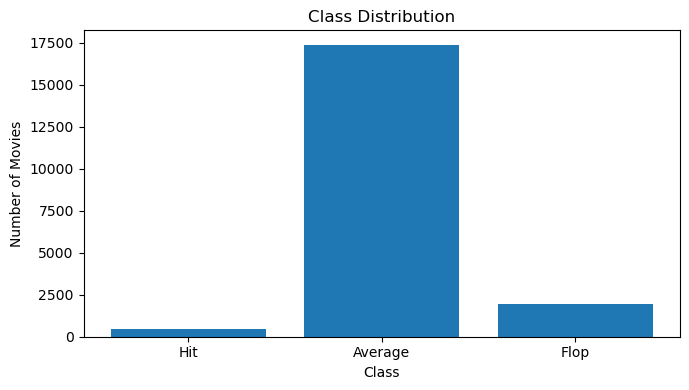

In [8]:
# Diagram: Class Distribution
counts = df["label"].value_counts().reindex(["Hit", "Average", "Flop"]).fillna(0).astype(int)

plt.figure(figsize=(7,4))
plt.bar(counts.index, counts.values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

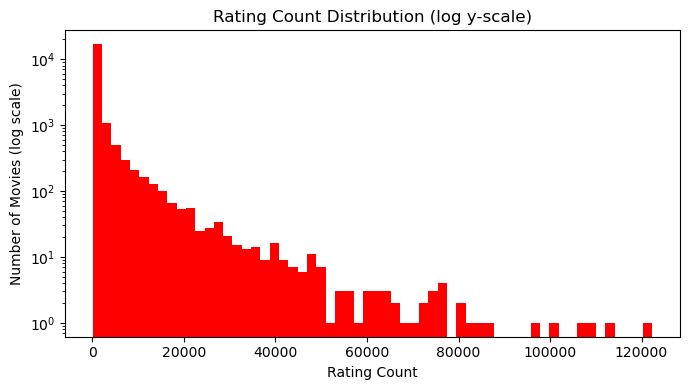

In [9]:
# Diagram: Rating Count Distribution
plt.figure(figsize=(7,4))
plt.hist(df["rating_count"], bins=60, color='red')
plt.yscale("log")
plt.title("Rating Count Distribution (log y-scale)")
plt.xlabel("Rating Count")
plt.ylabel("Number of Movies (log scale)")
plt.tight_layout()
plt.show()

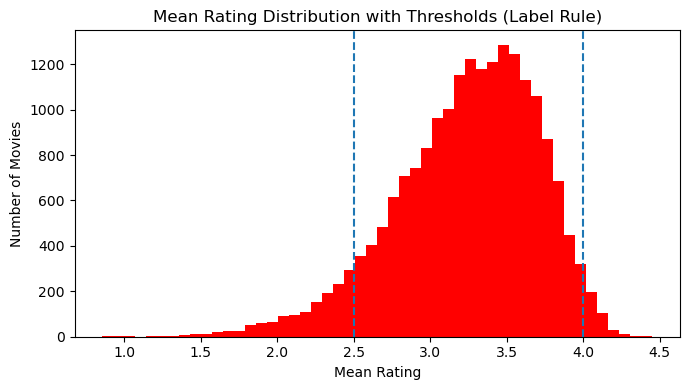

In [10]:
# Diagram: Mean Rating Distribution with Thresholds
plt.figure(figsize=(7,4))
plt.hist(df["rating_mean"], bins=50, color='red')
plt.axvline(AVERAGE_LOWER_THRESHOLD, linestyle="--")
plt.axvline(HIT_THRESHOLD, linestyle="--")
plt.title("Mean Rating Distribution with Thresholds (Label Rule)")
plt.xlabel("Mean Rating")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

In [11]:
# Prepare Features and Target
feature_cols = [c for c in df.columns if c not in ["movieId", "title", "label", "rating_mean"]]
X = df[feature_cols].select_dtypes(include=[np.number]).fillna(0)

le = LabelEncoder()
y = le.fit_transform(df["label"])

In [12]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [13]:
# Random Forest Training
rf = RandomForestClassifier(
  n_estimators=400,
  max_depth=20,
  min_samples_leaf=2,
  class_weight="balanced",
  random_state=RANDOM_STATE,
  n_jobs=-1
)
rf.fit(X_train, y_train);

In [14]:
# SVM Pipeline Training
svm = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", LinearSVC(C=0.3, class_weight="balanced", dual=False, max_iter=20000, random_state=RANDOM_STATE))
])
svm.fit(X_train, y_train);

In [15]:
# KNN Pipeline Training
knn = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", KNeighborsClassifier(n_neighbors=21, weights="distance"))
])
knn.fit(X_train, y_train);

In [16]:
# Accuracy and Macro F1 Scores
rf_pred = rf.predict(X_test)
svm_pred = svm.predict(X_test)
knn_pred = knn.predict(X_test)

print("Accuracy:")
print("Random Forest:", accuracy_score(y_test, rf_pred))
print("SVM:", accuracy_score(y_test, svm_pred))
print("KNN:", accuracy_score(y_test, knn_pred))

print("\nMacro F1:")
print("Random Forest:", f1_score(y_test, rf_pred, average="macro"))
print("SVM:", f1_score(y_test, svm_pred, average="macro"))
print("KNN:", f1_score(y_test, knn_pred, average="macro"))

Accuracy:
Random Forest: 0.9713779128672746
SVM: 0.9351570415400202
KNN: 0.92806484295846

Macro F1:
Random Forest: 0.896437433190712
SVM: 0.7994730986355005
KNN: 0.6352920588154706


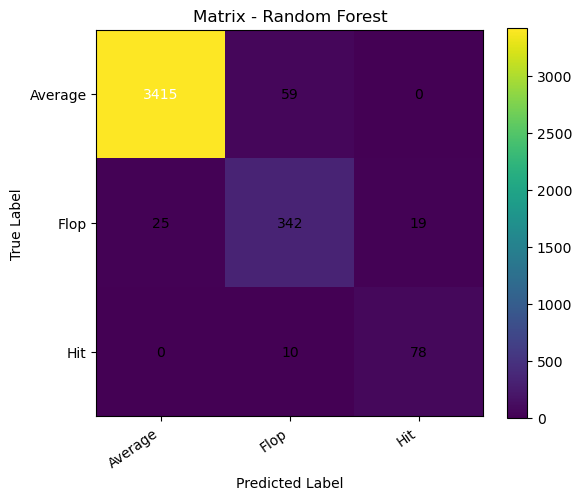

In [17]:
# Diagram: Matrix Random Forest
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrix - Random Forest")
plt.colorbar()

ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=35, ha="right")
plt.yticks(ticks, le.classes_)

thresh = cm.max() / 2.0 if cm.max() else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

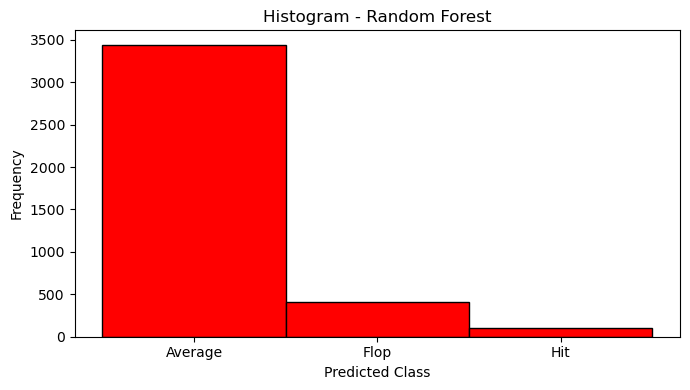

In [18]:
# Diagram: Histogram Random Forest
bins = np.arange(len(le.classes_) + 1) - 0.5

plt.figure(figsize=(7,4))
plt.hist(rf_pred, bins=bins, rwidth=1.0, color="red", edgecolor="black")
plt.xticks(range(len(le.classes_)), le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Histogram - Random Forest")
plt.tight_layout()
plt.show()

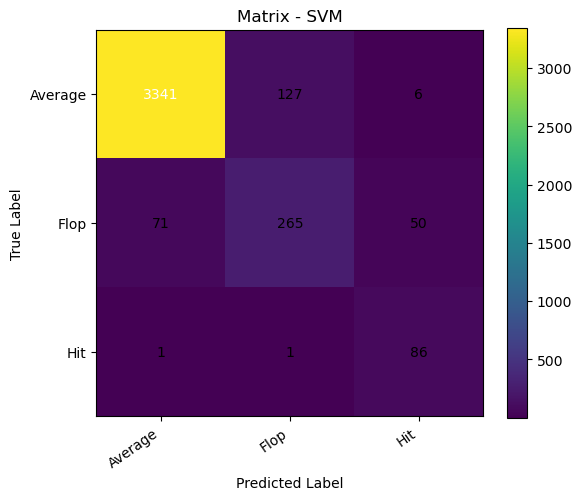

In [19]:
# Diagram: Matrix SVM
cm = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrix - SVM")
plt.colorbar()

ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=35, ha="right")
plt.yticks(ticks, le.classes_)

thresh = cm.max() / 2.0 if cm.max() else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


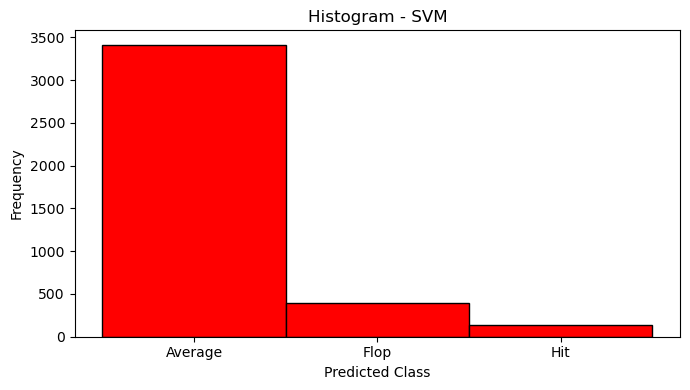

In [20]:
#Diagram: Histogram SVM
bins = np.arange(len(le.classes_) + 1) - 0.5

plt.figure(figsize=(7,4))
plt.hist(svm_pred, bins=bins, rwidth=1.0, color="red", edgecolor="black")
plt.xticks(range(len(le.classes_)), le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Histogram - SVM")
plt.tight_layout()
plt.show()

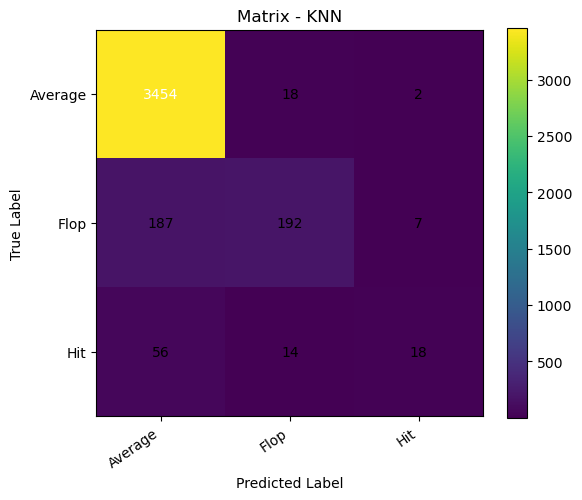

In [21]:
# Diagram: Matrix KNN
cm = confusion_matrix(y_test, knn_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrix - KNN")
plt.colorbar()

ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=35, ha="right")
plt.yticks(ticks, le.classes_)

thresh = cm.max() / 2.0 if cm.max() else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


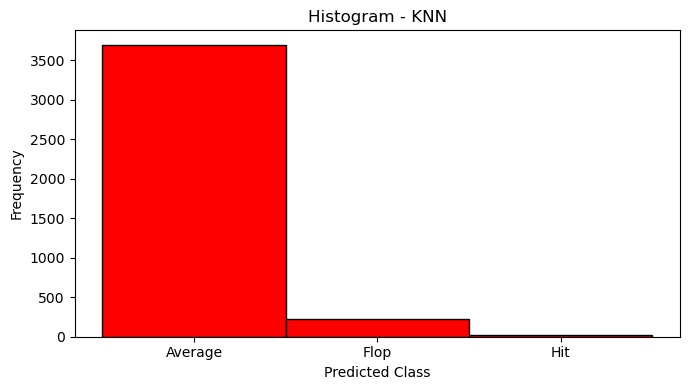

In [22]:
# Diagram: Prediction KNN
bins = np.arange(len(le.classes_) + 1) - 0.5

plt.figure(figsize=(7,4))
plt.hist(knn_pred, bins=bins, rwidth=1.0, color="red", edgecolor="black")
plt.xticks(range(len(le.classes_)), le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Histogram - KNN")
plt.tight_layout()
plt.show()

In [23]:
# Movie Search and Selection Utility
def choose_movie_from_matches(max_show=50):
    query = input("Enter movie title keyword (exit to Quit): ").strip()
    if query.lower() == "exit":
        return None

    matches = df[df["title"].str.lower().str.contains(query.lower(), na=False)].copy()
    if matches.empty:
        print("No Matching Title Found")
        return None

    titles = matches["title"].tolist()

    if len(titles) > max_show:
        print(f"Found {len(titles)} matches. Showing first {max_show}.")
        titles_to_show = titles[:max_show]
    else:
        print(f"Found {len(titles)} matches.")
        titles_to_show = titles

    for i, t in enumerate(titles_to_show, start=1):
        print(f"{i}. {t}")

    choice = input(f"Choose 1-{len(titles_to_show)} (exit to quit): ").strip().lower()
    if choice == "exit":
        return None
    if not choice.isdigit():
        print("Invalid choice")
        return None

    idx = int(choice)
    if not (1 <= idx <= len(titles_to_show)):
        print("Out of range")
        return None

    return df[df["title"] == titles_to_show[idx - 1]].iloc[0]

In [24]:
# Random Forest Prediction Output
row = choose_movie_from_matches()
if row is None:
    pass
else:
    X_row = row[feature_cols].to_frame().T
    pred = rf.predict(X_row)[0]
    print("Movie:", row["title"])
    print("Random Forest Prediction:", le.inverse_transform([pred])[0])

Enter movie title keyword (exit to Quit):  exit


In [25]:
# SVM Prediction Output
row = choose_movie_from_matches()
if row is None:
    pass
else:
    X_row = row[feature_cols].to_frame().T
    pred = svm.predict(X_row)[0]
    print("Movie:", row["title"])
    print("SVM Prediction:", le.inverse_transform([pred])[0])

Enter movie title keyword (exit to Quit):  exit


In [26]:
# KNN Prediction Output
row = choose_movie_from_matches()
if row is None:
    pass
else:
    X_row = row[feature_cols].to_frame().T
    pred = knn.predict(X_row)[0]
    print("Movie:", row["title"])
    print("KNN Prediction:", le.inverse_transform([pred])[0])

Enter movie title keyword (exit to Quit):  exit


Accuracy Comparison (All Three Models)
Random Forest: 0.9713779128672746
SVM: 0.9351570415400202
KNN: 0.92806484295846

Random Forest Metrics
              precision    recall  f1-score   support

     Average       0.99      0.98      0.99      3474
        Flop       0.83      0.89      0.86       386
         Hit       0.80      0.89      0.84        88

    accuracy                           0.97      3948
   macro avg       0.88      0.92      0.90      3948
weighted avg       0.97      0.97      0.97      3948


SVM Metrics
              precision    recall  f1-score   support

     Average       0.98      0.96      0.97      3474
        Flop       0.67      0.69      0.68       386
         Hit       0.61      0.98      0.75        88

    accuracy                           0.94      3948
   macro avg       0.75      0.88      0.80      3948
weighted avg       0.94      0.94      0.94      3948


KNN Metrics
              precision    recall  f1-score   support

     Average   

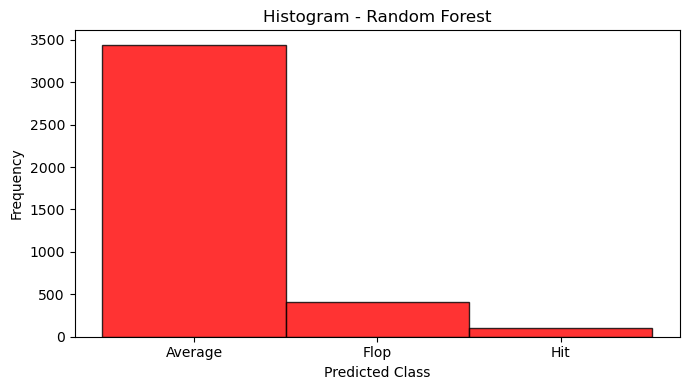

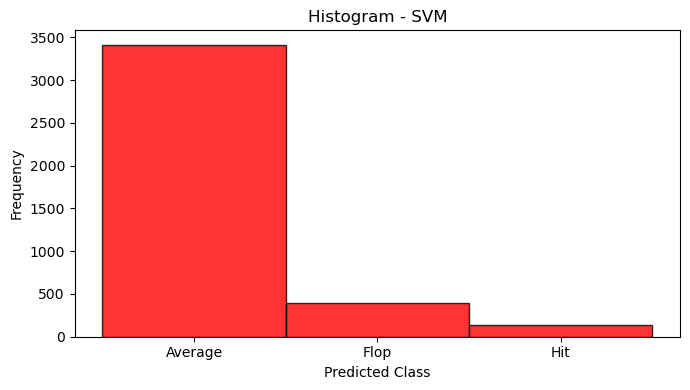

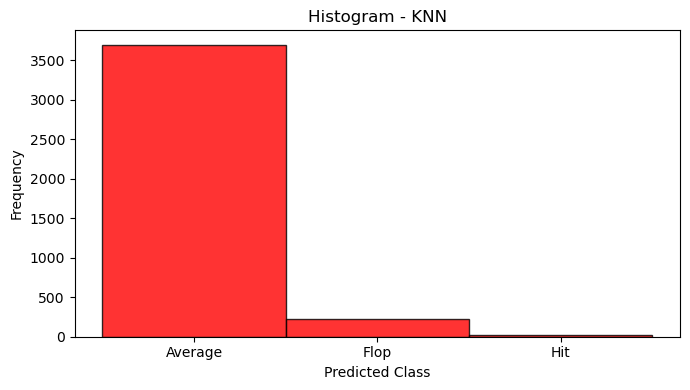

In [27]:
# Comparison between all three modules (Accuracy, Precision, Recall, F1, Support + Histograms)

# Predictions
rf_pred  = rf.predict(X_test)
svm_pred = svm.predict(X_test)
knn_pred = knn.predict(X_test)

# Accuracy
rf_acc  = accuracy_score(y_test, rf_pred)
svm_acc = accuracy_score(y_test, svm_pred)
knn_acc = accuracy_score(y_test, knn_pred)

print("Accuracy Comparison (All Three Models)")
print("Random Forest:", rf_acc)
print("SVM:", svm_acc)
print("KNN:", knn_acc)

# Precision, Recall, F1, Support (per class + averages)
print("\nRandom Forest Metrics")
print(classification_report(y_test, rf_pred, target_names=le.classes_))

print("\nSVM Metrics")
print(classification_report(y_test, svm_pred, target_names=le.classes_))

print("\nKNN Metrics")
print(classification_report(y_test, knn_pred, target_names=le.classes_))

# Histograms 
bins = np.arange(len(le.classes_) + 1) - 0.5

plt.figure(figsize=(7,4))
plt.hist(rf_pred, bins=bins, rwidth=1.0, color="red", edgecolor="black", alpha=0.8)
plt.xticks(range(len(le.classes_)), le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Histogram - Random Forest")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(svm_pred, bins=bins, rwidth=1.0, color="red", edgecolor="black", alpha=0.8)
plt.xticks(range(len(le.classes_)), le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Histogram - SVM")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(knn_pred, bins=bins, rwidth=1.0, color="red", edgecolor="black", alpha=0.8)
plt.xticks(range(len(le.classes_)), le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Histogram - KNN")
plt.tight_layout()
plt.show()